In [31]:
# To import the labelled files for datasets
# For Google Colab

from google.colab import files
uploaded = files.upload()

Saving labeled_mayb_conc.csv to labeled_mayb_conc (2).csv


In [32]:
# To install transformers library
# to use BERT transformer

!pip install transformers
     

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
# Importing all the libraries which will be used later on

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Importing all Torch libraries to use

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
import warnings
warnings.filterwarnings('ignore')

In [34]:

%config InlineBackend.figure_format='retina'

# Getting graph Designs to use ahead

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Initializing random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Setting GPU, if there is one avaliable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [35]:
# Reading from labelled file
df =  pd.read_csv('labeled_mayb_conc.csv')
df.head()

,Review,Positive,Negative,Neutral,Compound,Sentiment
0,asizebase 3,0.000,0.000,1.000,0.0000,Neutral
1,Maybelline is a tried and tested brand Love th...,0.242,0.044,0.714,0.8748,Positive
2,I use these on all of my clients perfect Matte...,0.197,0.073,0.730,0.5994,Positive
3,Great value and it works fine,0.735,0.000,0.265,0.8074,Positive
4,i can never find this shade in stores and deci...,0.208,0.000,0.792,0.6369,Positive


In [36]:
# Checking if any row in 
# Review column is null

df.isnull().sum()

Review       7
Positive     0
Negative     0
Neutral      0
Compound     0
Sentiment    0
dtype: int64

In [37]:
# Initializing BERT tokenizer ...
# bert-base-cased in our case

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [38]:
# Checking some common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set 

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [39]:
# Review is an important column and it should not be null,
# Initializing null review values

token_lens = []
i = 0
for txt in df.Review.values:
    df.fillna(method='ffill', inplace=True)
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Review       0
Positive     0
Negative     0
Neutral      0
Compound     0
Sentiment    0
dtype: int64


Text(0.5, 0, 'Token count')

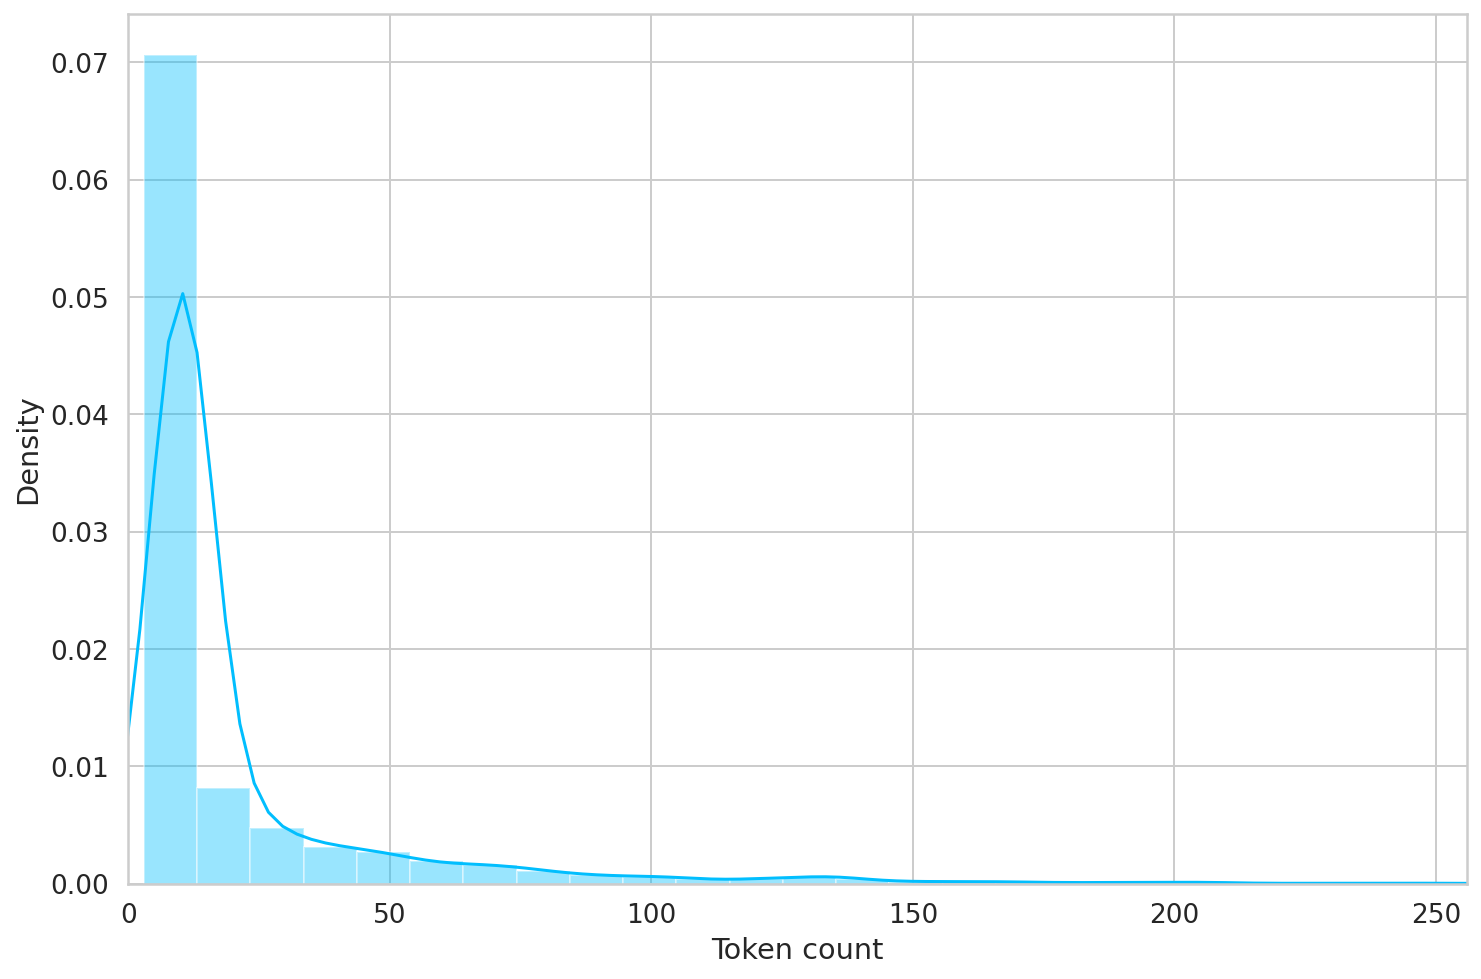

In [40]:
# Plot the distribution of review lengths 
# To decide on maximum length later on 

print(df.isnull().sum())
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [41]:
# Choosing length according to dataset

MAX_LEN = 200

In [42]:
# Converting labelled sentiments in numbering
# To later on use as targets in model

def to_sentiment(rating):
    
   
    if rating == 'Negative':
        return 0
    elif rating == 'Neutral':
        return 1
    else:
        return 2
i = 0
# Add to Sentiment column
for x in df.Sentiment:
    df.Sentiment[i]=to_sentiment(x)
    i+=1
    

In [43]:
# GPReviewDataset class to initialize 
class GPReviewDataset(Dataset):
    # Constructor Function 
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    # Length magic method
    def __len__(self):
        return len(self.reviews)
    
    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # Encoded format to be returned 
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [44]:
# Dividing into training and testing datasets
# 80/20 ratio...

df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(4031, 6) (504, 6) (504, 6)


In [45]:
# Function to load dataset
# and pass into GPReviewDataset Class to be used later on

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.Review.to_numpy(),
        targets=df.Sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    # returning value of dataloader
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [46]:
# Initliazing batch_size, test, train and val data loaders
        
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [47]:
# Examples to check if all values
#  are working fine or not

data = next(iter(train_data_loader))
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 200])
torch.Size([16, 200])
torch.Size([16])


In [48]:
# Initializing BERT Model ...
# bert-base-cased in our case

bert_model = BertModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
# Making the Sentiment Classifier class to classify all sentiments

class SentimentClassifier(nn.Module):

    # Constructor of the class 
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    # Forward propagation class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
        return_dict=False
        )
        #  Add a dropout layer 
        output = self.drop(pooled_output)
        return self.out(output)

In [50]:
# Instantiate the model and move to classifier
class_names = ['negative', 'neutral', 'positive']

# Pass all classes to sentiment classifier

model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
# Printing hidden size of BERT classifier
print(bert_model.config.hidden_size)

768


In [52]:
# Initializing Number of iterations 
# In out case, 4
EPOCHS = 4

# Initializing Optimizer Adam 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
# Initializing Total steps 
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function 
loss_fn = nn.CrossEntropyLoss().to(device)

In [53]:

# Function for a training in a single epoch
# All the training of the model takes place in this function

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    print("In Train Epoch")

    # assing in data loader

    for d in data_loader:
        print("In Data Loader")
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        # Setting output
    
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Making predictions...
        print("Before pred")
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        print("After")

        # For Backward propagatiom...
        loss.backward()
        print("After loss")

        # For Gradient Descent...
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        print("All")
        
    # Return accuracy by calculating losses as well
    return correct_predictions.double() / n_examples, np.mean(losses)

In [54]:

# Function for a testing in a single epoch
# All the testing of the model takes place in this function

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
           
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            print("pred:" ,preds)
            print("target:"   ,targets)
            correct_predictions += torch.sum(preds == targets)
            print("CCCC",  correct_predictions)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [55]:
%%time

history = defaultdict(list)
best_accuracy = 0

# To iterate through all epochs

for epoch in range(EPOCHS):
    
    # Show epoch number etc

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # Train data by passing through function
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print("Trained" )
    print(f"Train loss {train_loss} accuracy {train_acc}")
    

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    
    # Print all the information related to modeling
    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Streaming output truncated to the last 5000 lines.
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In Data Loader
Before pred
After
After loss
All
In D

In [56]:
# This function is used to get all the predixtions to pass into 
# the confusion matrix
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [57]:
# Getting predictions of the model

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [58]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.76      0.66      0.70        29
     neutral       0.95      0.99      0.97       203
    positive       0.97      0.95      0.96       272

    accuracy                           0.95       504
   macro avg       0.89      0.87      0.88       504
weighted avg       0.95      0.95      0.95       504



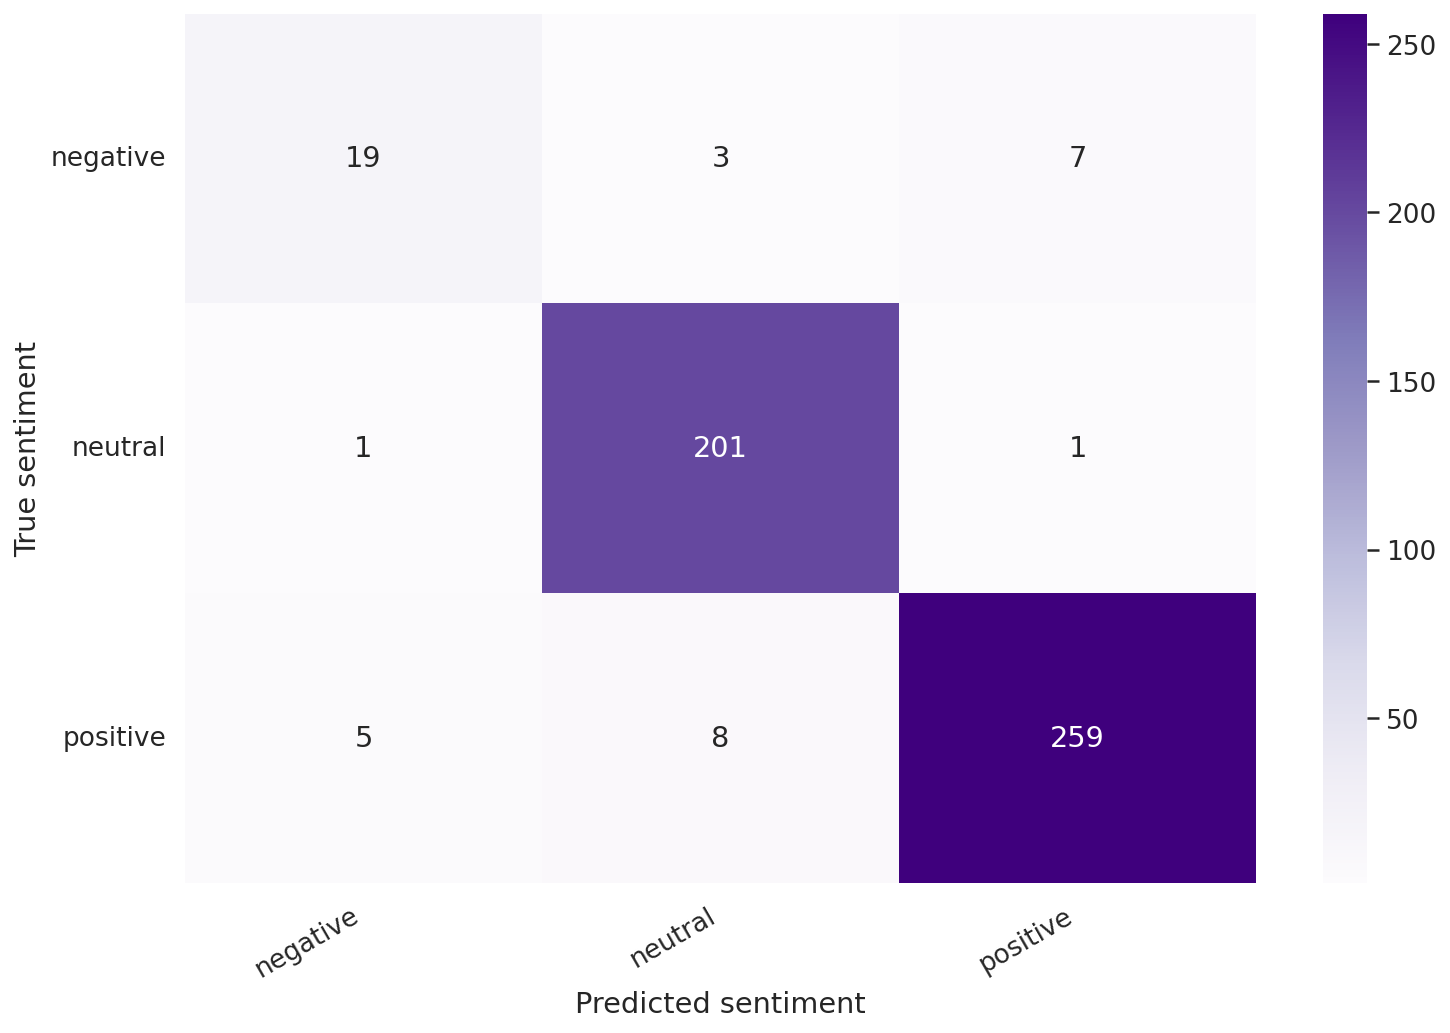

In [71]:
# This function is used to visualize confusion matrix of one epoch

def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Purples")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)